In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from src.models.model_diff_modular_legacy import ModularDiffModel

In [3]:
folder = "/share/home/lukash/checkpoints_bert_L4/seed{}"
experiment_name_seed0 = "bert_uncased_L-4_H-256_A-4-fixmask0.1-modular.pt"
experiment_name = "bert_uncased_L-4_H-256_A-4-fixmask0.1-modular-sparse_task.pt"

In [4]:
# encoder.embeddings.word_embeddings
# encoder.embeddings.position_embeddings
# encoder.embeddings.token_type_embeddings
# encoder.embeddings.LayerNorm
# encoder.encoder.layer.0.attention.self.query

sparsity_fn = lambda x: round(x[2]/x[0],2)

model_dicts = []
model_layer_dicts = []
model_module_dicts = []
for exp_idx in range(5):
    exp_name = experiment_name_seed0 if exp_idx==0 else experiment_name
    filepath = os.path.join(folder.format(exp_idx), exp_name)
    model = ModularDiffModel.load_checkpoint(filepath)

    model_dict = {}
    for n,m in model.get_encoder_base_modules(return_names=True):
        # n_p, n_p_zero, n_p_one
        model_dict[n] = [model._count_non_zero_params_for_module(m, idx) for idx in range(2)]

    model_module_dict = {}
    unique_modules = set([(x[11:] if x[:10]=="embeddings" else x[16:]) for x in model_dict.keys() if x!="pooler.dense"])
    for module_name in unique_modules:
        for k,v in model_dict.items():
            if k[-len(module_name):] == module_name:
                try:
                    model_module_dict[module_name] += np.array(v)
                except KeyError:
                    model_module_dict[module_name] = np.array(v)
    model_module_dict = {k:[sparsity_fn(v) for v in vals] for k,vals in model_module_dict.items()}
    model_dict = {k:[sparsity_fn(v) for v in vals] for k,vals in model_dict.items()}

    model_dicts.append(model_dict)
    model_module_dicts.append(model_module_dict)

    dicts = [model._count_non_zero_params_per_layer(idx) for idx in range(2)]
    model_layer_dicts.append({k:(sparsity_fn(v0), sparsity_fn(v1)) for (k,v0),v1 in zip(dicts[0].items(), dicts[1].values())})

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing B

In [5]:
model_layer_dict = {}
for k in model_layer_dicts[0].keys():
    ar = np.array([d[k] for d in model_layer_dicts])
    
    model_layer_dict[k] = (ar.mean(0), ar.std(0))

In [6]:
model_module_dict = {}
for k in model_module_dicts[0].keys():
    ar = np.array([d[k] for d in model_module_dicts])
    
    model_module_dict[k] = (ar.mean(0), ar.std(0))

In [7]:
model_dict = {}
for i in model_dicts[0].keys():
    ar = np.array([d[i] for d in model_dicts])
    model_dict[i] = (ar.mean(0), ar.std(0))

In [8]:
layer_name = "encoder.layer.{}"
layer_list = []
for i in range(4):
    n = layer_name.format(i)
    layer_dict = {}
    for k, v in model_dict.items():
        if k[:15] == n:
            layer_dict[k[16:]] = v
    layer_list.append(layer_dict)

In [9]:
# # https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html#sphx-glr-gallery-lines-bars-and-markers-horizontal-barchart-distribution-py

# n_layers = len(layer_list)
# n_modules = len(layer_list[0])
# module_names = list(layer_list[0].keys())

# labels = [f"Layer {i}" for i in range(n_layers)]
# data = np.ones((n_layers*2,n_modules)) / n_modules
# data_cum = data.cumsum(axis=1)
# colors = [plt.get_cmap('Blues'), plt.get_cmap('Oranges')]

# offset = (1 / n_modules) / 2
# y_centers = np.arange(8)-np.arange(1,9)/2
# xtick_positions = np.arange(offset, 1, step=1/n_modules)
# ytick_positions = np.arange(4)-0.25
# hline_positions = np.arange(5)-0.75

# title_fontsize = 16
# text_fontsize = 12
# plt.figure(figsize=(10,8))
# for i in range(n_modules):
#     m = module_names[i]
#     averages, error_margins = [np.stack(x) for x in zip(*[l[m] for l in layer_list])]
#     values0, values1, errors0, errors1 = averages[:,0], averages[:,1], error_margins[:,0], error_margins[:,1]
#     widths = data[:, i]
#     starts = data_cum[:, i] - widths
#     color = []
#     color_fn = lambda x: abs(x-1)-0.2
#     for v0, v1 in zip(values0, values1):
#         color.extend([colors[0](color_fn(v0)), colors[1](color_fn(v1))])
#     plt.barh(y_centers, widths, left=starts, height=0.5, color=color)
#     xcenters = starts + widths / 2
#     text_color = "black"
#     # text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
#     for y, x, v, e in zip(y_centers, xcenters, averages.flatten(), error_margins.flatten()):
#         plt.text(x, y, "{:.0%}\n$\pm${:.0%}".format(v, e), ha='center', va='center', color=text_color, fontsize=text_fontsize)

# spacing = widths / 2
# plt.barh(y_centers, spacing, left=np.ones((8,)), height=0.5, color="white")

# starts=np.ones((8,)) + spacing
# averages, error_margins = [np.stack(x) for x in zip(*model_layer_dict.values())]
# color = []
# for i, v in enumerate(averages[1:].flatten()):
#     color.append(colors[int(not i%2==0)](color_fn(v)))
# plt.barh(y_centers, widths, left=starts, height=0.5, color=color)
# xcenters = starts + widths / 2
# for y, x, v, e in zip(y_centers, xcenters, averages.flatten(), error_margins.flatten()):
#     plt.text(x, y, "{:.0%}\n$\pm${:.0%}".format(v, e), ha='center', va='center', color=text_color, fontsize=text_fontsize)

# for pos in hline_positions:
#     plt.hlines(pos, 0, 1, colors="black")
#     plt.hlines(pos, 1+spacing[0], 1+spacing[0]+widths[0], colors="black")
# plt.xticks(xtick_positions, labels=module_names, rotation=90, fontsize=10)
# plt.yticks(ytick_positions, labels=labels, fontsize=text_fontsize)
# plt.title("density per module", fontsize=title_fontsize)
# sns.despine(left=True, bottom=True, right=True)
# plt.tick_params(axis="x", bottom=False, pad=-5)

# custom_lines = [
#     Line2D([0], [0], color=colors[0](0.6), lw=10),
#     Line2D([0], [0], color=colors[1](0.6), lw=10)
# ]
# plt.legend(custom_lines, ["biased", "debiased"], bbox_to_anchor=(0.98, -0.3), frameon=False)

# plt.tight_layout()
# plt.savefig("density_per_module.png")
# plt.show()

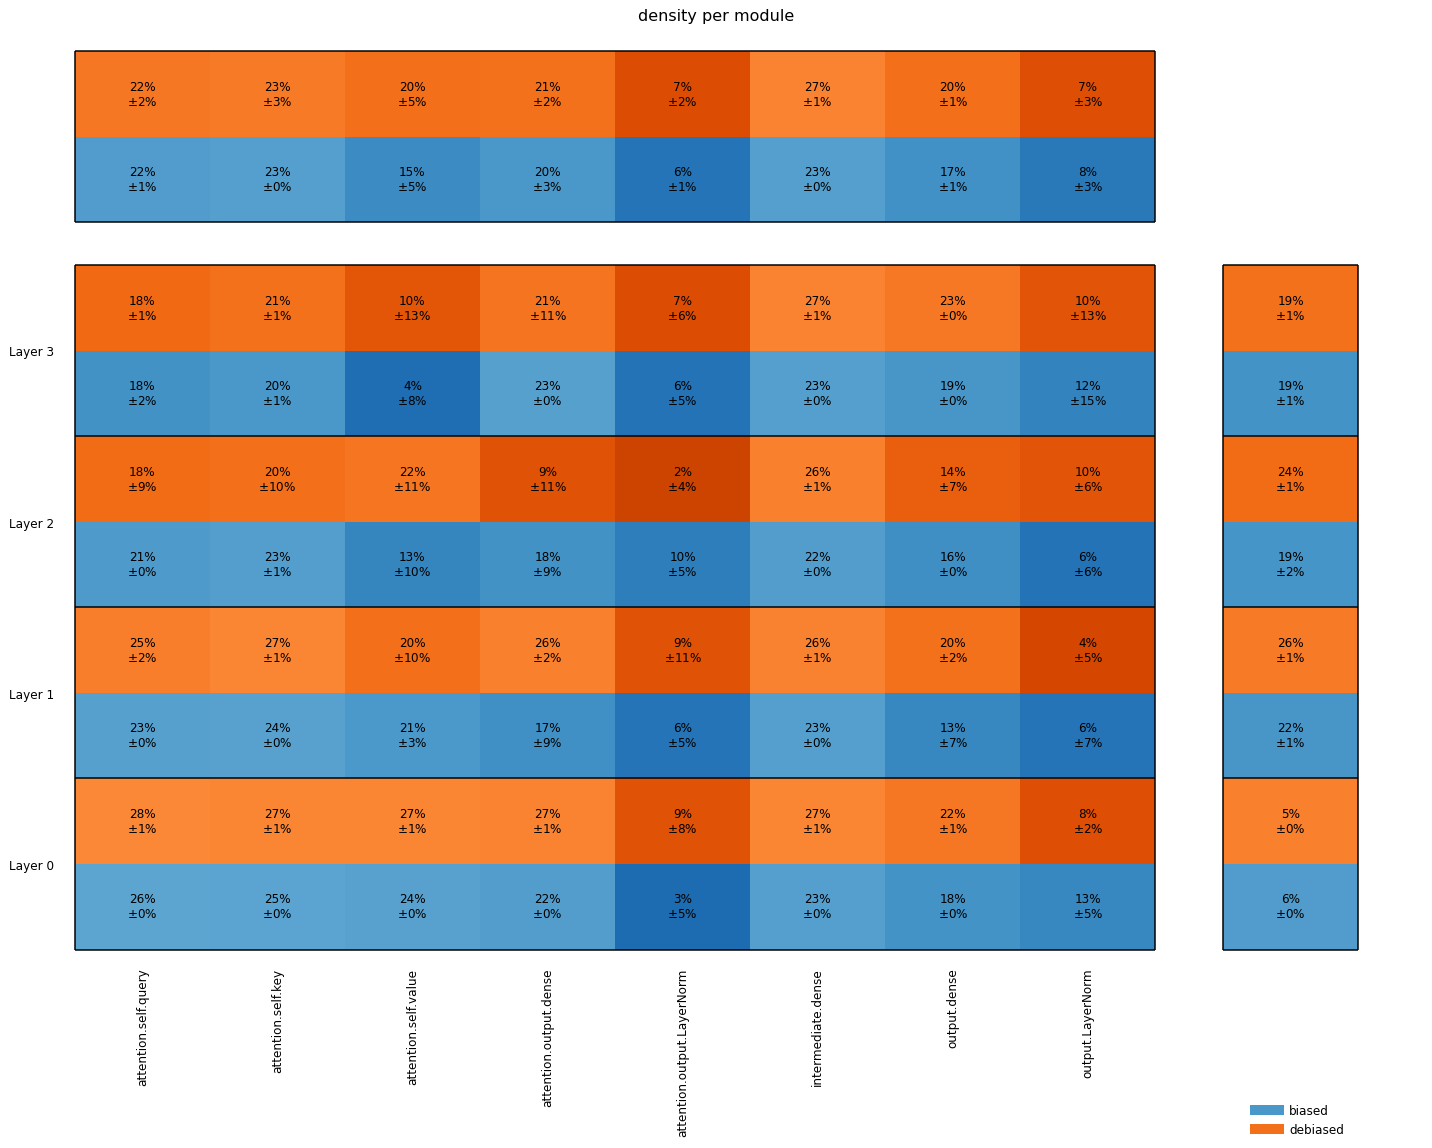

In [24]:
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html#sphx-glr-gallery-lines-bars-and-markers-horizontal-barchart-distribution-py

n_layers = len(layer_list)
n_modules = len(layer_list[0])
module_names = list(layer_list[0].keys())

labels = [f"Layer {i}" for i in range(n_layers)]
data = np.ones((n_modules,)) / n_modules
data_cum = data.cumsum()
colors = [plt.get_cmap('Blues'), plt.get_cmap('Oranges')]
colors_top = ["w", "k"]

offset = (1 / n_modules) / 2
y_centers = np.arange(8)-np.arange(1,9)/2
y_centers_adj = np.concatenate([y_centers, [y_centers[-1]+0.5, y_centers[-1]+0.25+0.5, y_centers[-1]+0.25+1]])
xtick_positions = np.arange(offset, 1, step=1/n_modules)
ytick_positions = np.arange(4)-0.25
hline_positions = np.arange(5)-0.75

title_fontsize = 16
text_fontsize = 12
plt.figure(figsize=(20,16))
plt.barh(y_centers, data[0]/2, left=0-data[0]/2, height=0.5, color="w")
for i in range(n_modules):
    m = module_names[i]
    m_averages, m_error_margins = model_module_dict[m]
    averages, error_margins = [np.stack(x) for x in zip(*[l[m] for l in layer_list])]
    values0, values1, errors0, errors1 = averages[:,0], averages[:,1], error_margins[:,0], error_margins[:,1]
    width = data[i]
    start = data_cum[i] - width
    color = []
    color_fn = lambda x: abs(x-1)-0.2
    for v0, v1 in zip(values0, values1):
        color.extend([colors[0](color_fn(v0)), colors[1](color_fn(v1))])
    color.append("w")
    color.extend([colors[i](color_fn(m_averages[i])) for i in range(2)])
    plt.barh(y_centers_adj, width, left=start, height=0.5, color=color)
    text_color = "black"
    # text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    x = start + width / 2
    for y, v, e in zip(y_centers, averages.flatten(), error_margins.flatten()):
        plt.text(x, y, "{:.0%}\n$\pm${:.0%}".format(v, e), ha='center', va='center', color=text_color, fontsize=text_fontsize)
    for y, v, e in zip(y_centers_adj[-2:], m_averages.flatten(), m_error_margins.flatten()):
        plt.text(x, y, "{:.0%}\n$\pm${:.0%}".format(v, e), ha='center', va='center', color=text_color, fontsize=text_fontsize)

spacing = width / 2
plt.barh(y_centers, spacing, left=1, height=0.5, color="w")

start = 1 + spacing
averages, error_margins = [np.stack(x) for x in zip(*model_layer_dict.values())]
color = []
for i, v in enumerate(averages[1:].flatten()):
    color.append(colors[int(not i%2==0)](color_fn(v)))
plt.barh(y_centers, width, left=start, height=0.5, color=color)
x = start + width / 2
for y, v, e in zip(y_centers, averages.flatten(), error_margins.flatten()):
    plt.text(x, y, "{:.0%}\n$\pm${:.0%}".format(v, e), ha='center', va='center', color=text_color, fontsize=text_fontsize)

for pos in hline_positions:
    plt.hlines(pos, 0, 1, colors="black")
    plt.hlines(pos, 1+spacing, 1+spacing+width, colors="black")
plt.hlines(pos+0.25, 0, 1, colors="black")
plt.hlines(pos+1.25, 0, 1, colors="black")
for x in [0,1,1+spacing,1+spacing+width]:
    plt.vlines(x, y_centers[0]-0.25, y_centers[-1]+0.25, colors="black")
for x in [0,1]:
    plt.vlines(x, y_centers_adj[-2]-0.25, y_centers_adj[-1]+0.25, colors="black")
plt.xticks(xtick_positions, labels=module_names, rotation=90, fontsize=text_fontsize)
plt.yticks(ytick_positions, labels=labels, fontsize=text_fontsize)
plt.title("density per module", fontsize=title_fontsize, y=.98)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-30)
plt.tick_params(axis="y", left=False, pad=-50)

custom_lines = [
    Line2D([0], [0], color=colors[0](0.6), lw=10),
    Line2D([0], [0], color=colors[1](0.6), lw=10)
]
plt.legend(custom_lines, ["biased", "debiased"], bbox_to_anchor=(0.95, -0.1), frameon=False, fontsize=text_fontsize)

plt.tight_layout()
plt.savefig("density_per_module.png")
plt.show()

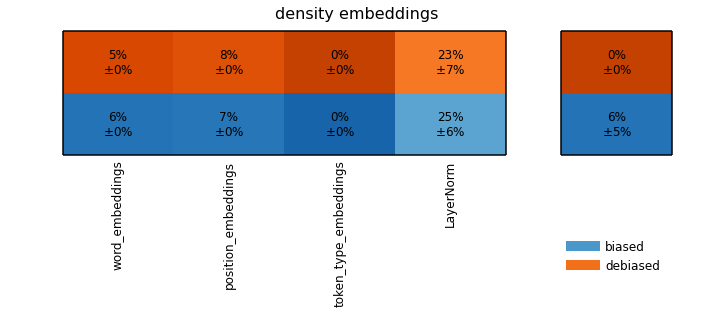

In [25]:
emb_dict = {k:v for k,v in model_dict.items() if k[:10]=="embeddings"}
n_modules = len(emb_dict)
module_names = [x.split(".")[-1] for x in emb_dict.keys()]

width = 0.25
starts = np.arange(1,n_modules+1) * width

title_fontsize = 16
text_fontsize = 12
plt.figure(figsize=(10,5))
plt.barh([i*width for i in range(2)], width/2, left=width/2, height=width, color="w")
for i, (start, m, (_m, (averages, error_margins))) in enumerate(zip(starts, module_names, emb_dict.items())):
    for idx, (a, e) in enumerate(zip(averages, error_margins)):
        color = colors[idx](color_fn(a))
        plt.barh(idx*width, width, left=start, height=width, color=color)
        plt.text(start+width/2, idx*width, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
for idx, (a, e) in enumerate(model_layer_dict[0]):
    plt.barh(idx*width, width/2, left=start+width, height=width, color="w")
    color = colors[idx](color_fn(a))
    plt.barh(idx*width, width, left=start+width*1.5, height=width, color=color)
    plt.text(start+width*2, idx*width, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)

for x in [0-width/2, width*1.5]:
    plt.hlines(x, starts[0], starts[-1]+width, colors="black")
    plt.hlines(x, starts[-1]+width*1.5, starts[-1]+width*2.5, colors="black")

for x in [width, 1+width, 1+width*1.5, 1+width*2.5]:
    plt.vlines(x, 0-width/2, width*1.5, colors="black")

plt.xticks(starts + width/2, labels=module_names, rotation=90, fontsize=text_fontsize)
plt.yticks([])
plt.title("density embeddings", fontsize=title_fontsize)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-5)

custom_lines = [
    Line2D([0], [0], color=colors[0](0.6), lw=10),
    Line2D([0], [0], color=colors[1](0.6), lw=10)
]
plt.legend(custom_lines, ["biased", "debiased"], bbox_to_anchor=(.95, -0.5), frameon=False, fontsize=text_fontsize)

plt.tight_layout()
plt.savefig("density_embedding.png")
plt.show()